<h1>SISTEMA DE RECONOCIMIENTO DE COVID</h1>

### Paso A: Importar librerias


In [41]:
# Importo las librerías necesarias para la visualización de imágenes
import matplotlib.pyplot as plt  # Para visualizar imágenes
import numpy as np  # Para operaciones numéricas y manejo de arrays
import os  # Para manejar las rutas de los archivos
# Importo las librerías de Keras para cargar y preprocesar imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Para aplicar transformaciones a las imágenes
from tensorflow.keras.preprocessing import image  # Para cargar imágenes y convertirlas en arrays
from tensorflow.keras.callbacks import EarlyStopping
# Importo Keras para cargar el modelo preentrenado
from tensorflow.keras.models import load_model  # Para cargar el modelo ya entrenado

# Importo capas y componentes necesarios de Keras
from tensorflow.keras.layers import *  # Para usar diferentes capas en un modelo (como Conv2D, MaxPooling2D, etc.)
from tensorflow.keras import layers, models  # Para definir el modelo en Keras

# Importo TensorFlow para trabajar con el modelo
import tensorflow as tf  # Para trabajar con modelos de deep learning en TensorFlow

# Importo Rectangle de matplotlib para dibujar cajas alrededor de las predicciones
from matplotlib.patches import Rectangle  # Para agregar rectángulos a las imágenes

# Importo pandas para trabajar con DataFrames (por ejemplo, almacenar datos de las imágenes)
import pandas as pd  # Para manejar datos estructurados como DataFrames

### Paso B: Definir ruta del datasets


In [1]:
train_path = r'C:/xampp/htdocs/bioscan/Covid19-dataset/train'
test_path = r'C:/xampp/htdocs/bioscan/ovid19-dataset/test'

### Paso 1: Preparación y Entrenamiento del Modelo
#### 1.1 Cargar y Preprocesar las Imágenes

In [5]:
# Creo el generador de datos para el entrenamiento, con normalización y un 20% para validación
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [26]:
# Creo el generador para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(
    'C:/xampp/htdocs/bioscan/Covid19-dataset/train/',  # Especifico la ruta principal donde están las carpetas de clases
    target_size=(224, 224),  # Redimensiono todas las imágenes a 224x224 píxeles
    batch_size=32,  # Defino el tamaño del batch (32 imágenes por vez)
    class_mode='categorical',  # Estoy haciendo clasificación multiclase
    subset='training'  # Uso este subconjunto para entrenamiento
)

Found 24246 images belonging to 3 classes.


In [11]:
# Creo el generador para el conjunto de validación
validation_generator = train_datagen.flow_from_directory(
    'C:/xampp/htdocs/bioscan/Covid19-dataset/train',  
    batch_size=32,  
    class_mode='categorical',  
    subset='validation'  # Este es el subconjunto para validación
)

Found 6060 images belonging to 3 classes.


In [28]:
# Defino una función para mostrar imágenes de las diferentes clases
def plot_image(image_classes):
    plt.figure(figsize=(12, 12))  # Ajusto el tamaño de la figura para que sea adecuada

    for i, category in enumerate(image_classes):
     
        category_path = os.path.join(train_path, category) 
        # Accedo a la carpeta 'images' dentro de cada categoría
        image_path = os.path.join(category_path, 'images')  
        
        # Verifico si la carpeta 'images' existe dentro de la categoría
        if not os.path.exists(image_path):
            print(f"La carpeta 'images' no existe en {category}")
            continue

        # Listo todas las imágenes en esa carpeta
        image_in_folder = os.listdir(image_path)  
        if len(image_in_folder) == 0:
            print(f"No hay imágenes en la carpeta {category}")
            continue
        
        first_image = image_in_folder[0]  # Tomo la primera imagen de la carpeta
        first_image_path = os.path.join(image_path, first_image)  # Obtengo la ruta completa de la imagen

        try:
            # Intento cargar la imagen
            img = image.load_img(first_image_path)  # Cargo la imagen
            img_array = image.img_to_array(img) / 255  # La convierto en un array y normalizo
        except PermissionError:
            # Si ocurre un error de permisos, lo manejo
            print(f"Permiso denegado para la imagen: {first_image_path}")
            continue
        except Exception as e:
            # Si hay otro tipo de error, lo manejo aquí
            print(f"Error al cargar la imagen {first_image_path}: {e}")
            continue

        # Muestro la imagen en una de las 3 subgráficas
        plt.subplot(1, 3, i + 1)  # 1 fila, 3 columnas
        plt.imshow(img_array)  # Muestro la imagen
        plt.title(category)  # Pongo el nombre de la categoría como título
        plt.axis('off')  # Desactivo los ejes para que la imagen se vea limpia

    plt.show()  # Finalmente, muestro todas las imágenes

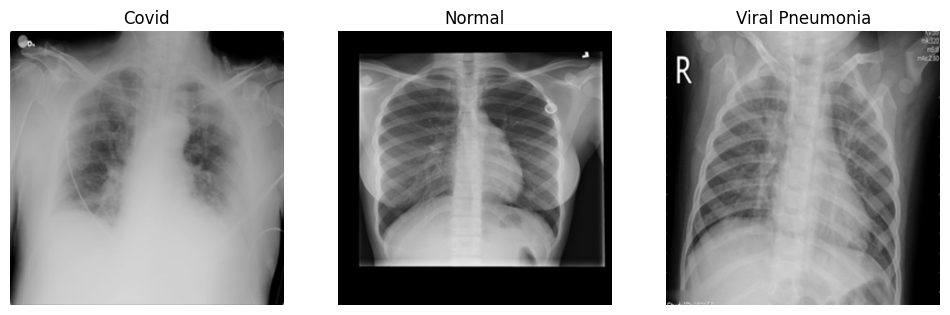

In [33]:
train_path = 'C:/xampp/htdocs/bioscan/Covid19-dataset/train'
test_path = train_path  # Si no tienes un directorio de prueba, puedes usar el directorio de entrenamiento para pruebas
image_classes = os.listdir(train_path) 
plot_image(image_classes)


In [34]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescalar los valores de los píxeles

In [45]:
test_data = test_datagen.flow_from_directory(
    test_path,  # Ruta al conjunto de prueba
    target_size=(224, 224),  # Tamaño de las imágenes
    batch_size=1,  # Tamaño del batch (uno a la vez)
    class_mode='categorical'  # Clasificación multiclase
)


Found 30306 images belonging to 3 classes.


#### 1.2 Definir el Modelo

In [36]:
# Definir la arquitectura del modelo
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),   # Especifico el input al inicio
    layers.Conv2D(32, (3, 3), activation='relu'),  # Primera capa convolucional
    layers.MaxPooling2D(2, 2),  # Capa de pooling
    layers.Conv2D(64, (3, 3), activation='relu'),  # Segunda capa convolucional
    layers.MaxPooling2D(2, 2),  # Capa de pooling
    layers.Conv2D(128, (3, 3), activation='relu'),  # Tercera capa convolucional
    layers.MaxPooling2D(2, 2),  # Capa de pooling
    layers.Flatten(),  # Aplanamos la salida
    layers.Dense(512, activation='relu'),  # Capa densa totalmente conectada
    layers.Dense(3, activation='softmax')  # Capa de salida (3 clases: Normal, Covid, Pneumonia)
])

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)


###### 1. El resumen muestra todas las capas del modelo, con su tipo y la forma de salida que produce.
###### 2. Nos indica cuántos parámetros tiene cada capa. Los parámetros son los pesos y sesgos que el modelo ajustará durante el entrenamiento.
###### 3. Es útil para verificar si las formas de las salidas de las capas son correctas. Por ejemplo, después de las capas convolucionales y de pooling, la forma de la salida debe coincidir con lo esperado.
###### 4. Al final, muestra el total de parámetros en el modelo, lo que nos da una idea de la complejidad del modelo y la cantidad de memoria que usará durante el entrenamiento.
######    Un número muy alto de parámetros puede indicar un modelo complejo que podría requerir más recursos computacionales o que tiene un riesgo de sobreajuste si los datos de entrenamiento son limitados.

In [42]:
# Compilar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Entrenar el modelo
model_history = model.fit(
    train_generator,
    epochs=7,  # Reducción de épocas para depuración
    validation_data=validation_generator,
    callbacks=[early_stopping]  # Detener entrenamiento si no mejora
)

Epoch 1/7
 95/758 ━━━━━━━━━━━━━━━━━━━━ 15:46 1s/step - accuracy: 0.6731 - loss: 0.7583

In [39]:
plt.plot(model_history.history['loss'],label='Train loss')
# Luego, trazo la curva de la pérdida (loss) para la validación
plt.plot(model_history.history['val_loss'], label='Validation loss')
# Agrego una leyenda para poder identificar ambas curvas en el gráfico
plt.legend()
plt.show()

NameError: name 'model_history' is not defined

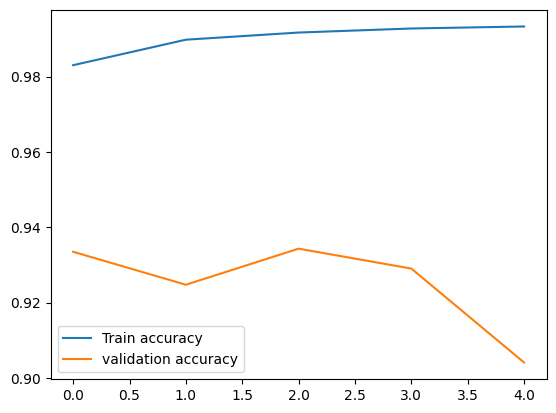

In [33]:
plt.plot(model_history.history['accuracy'],label='Train accuracy')
plt.plot(model_history.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

#### 1.3 Guardar el Modelo

In [194]:
# Guardar el modelo entrenado
# model.save('modelo_entrenado.h5')
model.save('modelo_entrenado.keras')

 ### <center>Paso 2: Pruebas </center>

In [ ]:
# Generador de imágenes de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

In [195]:
test_generator = test_datagen.flow_from_directory(
    'C:/Users/myasu/Documents/Covid19-dataset/test',  # Ruta donde están las imágenes de test
    target_size=(224, 224),  # Redimensionar las imágenes al tamaño adecuado
    batch_size=32,  # Tamaño del batch
    class_mode='categorical',  # Las etiquetas en formato one-hot (categorical)
    shuffle=False  # No barajamos las imágenes para obtener predicciones en orden
)

Found 251 images belonging to 3 classes.


#### Evaluación del Modelo en el Conjunto de Test:
Una vez que el modelo está cargado y el generador está configurado, recien procedemos a evaluar el rendimiento del modelo sobre las imágenes de test.

In [ ]:
# Evaluo el modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.6745 - loss: 3.6159
Test Loss: 4.085256099700928
Test Accuracy: 0.6533864736557007


#### Hacer Predicciones en las Imágenes de Test

In [ ]:
# Hacer predicciones en el conjunto de test
predictions = model.predict(test_generator)
# Convertiendo las probabilidades a clases (la clase con la probabilidad más alta)
predicted_classes = predictions.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step


##### Visualizar Imágenes con sus Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


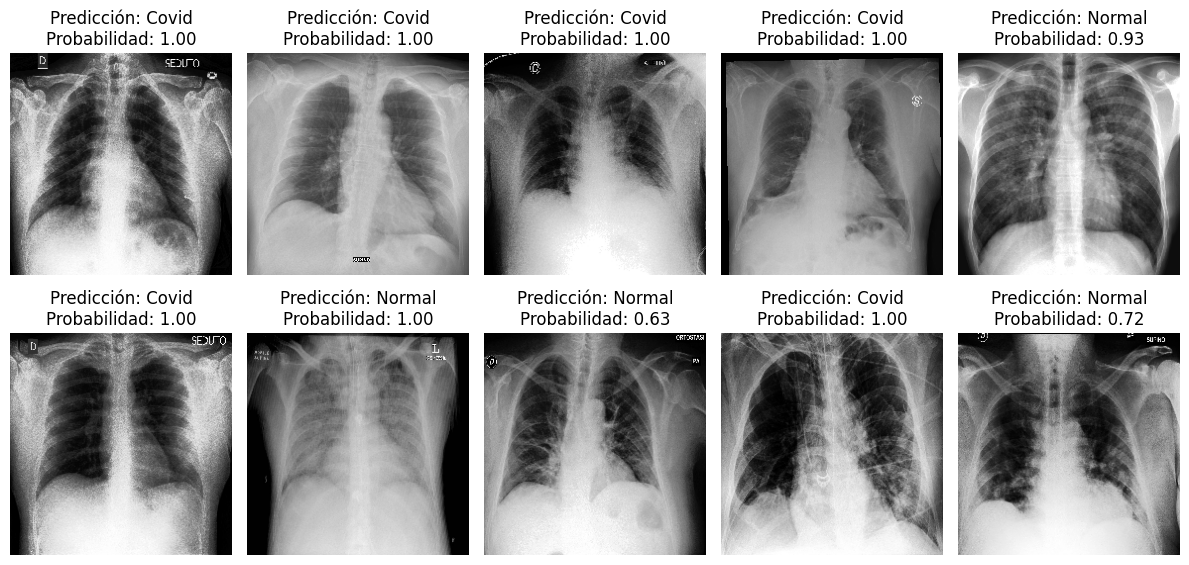

In [196]:
# Defino el número de imágenes a visualizar
num_images = 10
rows = 2  # Fijo el número de filas
cols = 5  # Fijo el número de columnas

# Creo la figura para mostrar las imágenes
plt.figure(figsize=(12, 6))  # Ajusto el tamaño de la figura

# Bucle para mostrar las imágenes y sus predicciones
for i in range(num_images):  # Recorro las primeras 10 imágenes
    # Obtengo la ruta de la imagen
    image_path = test_generator.filepaths[i]  # Ruta de la imagen
    
    # Cargo y redimensiono la imagen
    img = image.load_img(image_path, target_size=(224, 224))  # Redimensiono
    img_array = image.img_to_array(img) / 255.0  # Normalizo la imagen

    # Realizo la predicción
    img_array = np.expand_dims(img_array, axis=0)  # Expando dimensiones
    prediction = model.predict(img_array)  # Predigo la clase
    predicted_class = np.argmax(prediction, axis=1)[0]  # Obtengo el índice de la clase predicha
    
    # Mapear el índice a la clase
    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}  # Invierto el diccionario
    predicted_label = class_labels[predicted_class]  # Obtengo el nombre de la clase

    # Obtengo la probabilidad de la predicción
    prediction_prob = np.max(prediction)  # Probabilidad más alta
    
    # Muestra la imagen en un subgráfico
    plt.subplot(rows, cols, i + 1)  # Ubico la imagen en el gráfico
    plt.imshow(img)  # Muestra la imagen
    plt.title(f"Predicción: {predicted_label}\nProbabilidad: {prediction_prob:.2f}")  # Título con la predicción
    plt.axis('off')  # Quitar ejes

# Ajusto la disposición de las imágenes
plt.tight_layout()
plt.show()


Found 251 images belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


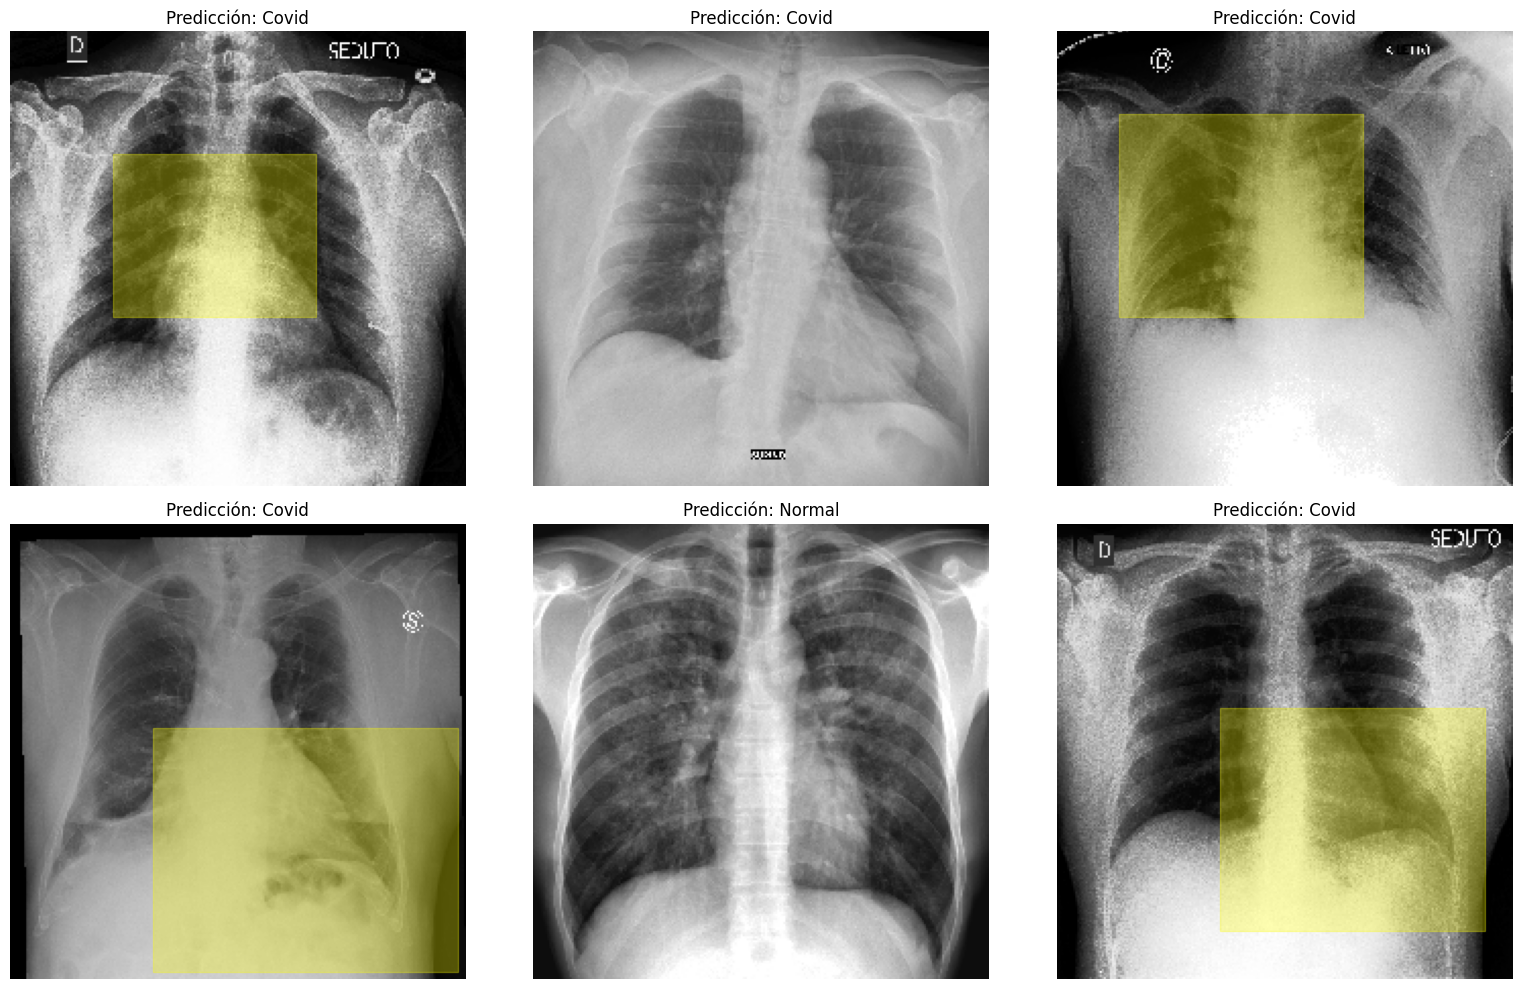

In [197]:
# Creo un DataFrame con las tres clases: Covid, Normal, y Pneumonia
train_class_df = pd.DataFrame({
    'patientId': ['patient_1', 'patient_2', 'patient_3', 'patient_4', 'patient_5', 'patient_6'],
    'Target': [1, 0, 2, 1, 0, 2],  # 1: Covid, 0: Normal, 2: Pneumonia
    'boxes': [
        [{'x': 50, 'y': 60, 'width': 100, 'height': 80}],  # Covid
        [],  # Normal
        [{'x': 30, 'y': 40, 'width': 120, 'height': 100}],  # Pneumonia
        [{'x': 70, 'y': 100, 'width': 150, 'height': 120}],  # Covid
        [],  # Normal
        [{'x': 80, 'y': 90, 'width': 130, 'height': 110}]   # Pneumonia
    ]
})

# Establezco la ruta de las imágenes de test
test_dir = 'C:/Users/myasu/Documents/Covid19-dataset/test'

# Creo el generador de imágenes, aplicando solo la normalización
test_datagen = ImageDataGenerator(rescale=1./255)

# Inicializo el generador de imágenes desde la carpeta de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Defino una función para mostrar imágenes con sus predicciones y cajas
def show_images_with_boxes(data, model, test_generator):
    # Obtengo las rutas de las imágenes desde el generador
    image_paths = test_generator.filepaths
    img_data = data.to_dict(orient='records')

    # Calculo cuántas filas necesito para mostrar las imágenes
    rows = int(np.ceil(len(img_data) / 3))
    f, ax = plt.subplots(rows, 3, figsize=(16, 5*rows))
    ax = ax.flatten()

    # Itero sobre los datos y muestro las imágenes
    for i, data_row in enumerate(img_data):
        image_path = image_paths[i]  # Accedo a la ruta de la imagen
        img = load_img(image_path, target_size=(224, 224))  # Cargo la imagen
        img_array = img_to_array(img) / 255.0  # Preproceso la imagen

        # Expando las dimensiones de la imagen para que sea compatible con el modelo
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)  # Realizo la predicción
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Mapear las clases predichas
        class_indices = test_generator.class_indices
        class_labels = {v: k for k, v in class_indices.items()}
        predicted_label = class_labels[predicted_class]

        # Muestro la imagen y su predicción
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f"Predicción: {predicted_label}")

        # Si existen cajas, las dibujo sobre la imagen
        for box in data_row['boxes']:
            if box:
                ax[i].add_patch(Rectangle(xy=(box['x'], box['y']), width=box['width'], height=box['height'],
                                          color="yellow", alpha=0.3))

    plt.tight_layout()  # Ajusto la distribución de las imágenes
    plt.show()  # Muestro las imágenes
    plt.close()  # Cierro la figura para evitar salidas adicionales

# Cargo el modelo previamente entrenado
model = load_model('modelo_entrenado.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Muestro las imágenes con las predicciones y las cajas
show_images_with_boxes(train_class_df, model, test_generator)


Found 251 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━

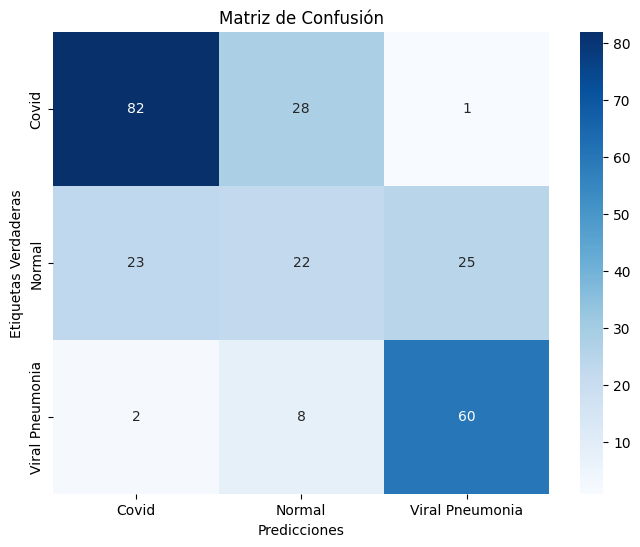

In [198]:
# Cargar el modelo previamente entrenado
model = load_model('modelo_entrenado.h5')

# Definir la ruta de las imágenes de test
test_dir = 'C:/Users/myasu/Documents/Covid19-dataset/test'

# Crear el generador de imágenes para normalizar
test_datagen = ImageDataGenerator(rescale=1./255)

# Generar las imágenes desde el directorio de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Inicializo listas para guardar las predicciones y las etiquetas verdaderas
predictions = []
true_labels = []

# Itero sobre todas las imágenes del generador para hacer predicciones
for img_path, true_label in zip(test_generator.filepaths, test_generator.classes):
    img = load_img(img_path, target_size=(224, 224))  # Cargar la imagen
    img_array = img_to_array(img) / 255.0  # Normalizar la imagen
    img_array = np.expand_dims(img_array, axis=0)  # Expando las dimensiones
    prediction = model.predict(img_array)  # Realizo la predicción
    predicted_class = np.argmax(prediction, axis=1)[0]  # Obtengo la clase predicha
    
    predictions.append(predicted_class)  # Almaceno la predicción
    true_labels.append(true_label)  # Almaceno la etiqueta verdadera

# Calcular la matriz de confusión para evaluar las predicciones
cm = confusion_matrix(true_labels, predictions)

# Obtener los nombres de las clases para mostrar en el gráfico
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}  # Invierto el diccionario de clases
class_names = list(class_labels.values())  # Lista de nombres de clases

# Visualizo la matriz de confusión usando un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.show()


## <center> Prueba Final </center>

In [178]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


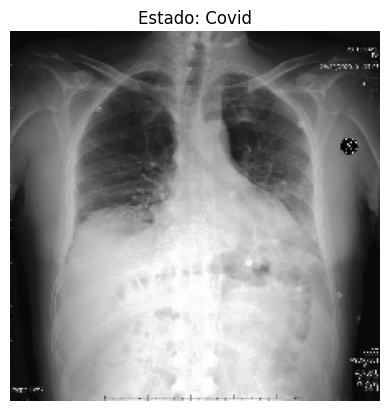

In [ ]:
# Función de predicción mostrando solo la etiqueta real
def prediction(test_image, actual_label=None):
    # Cargar y preprocesar la imagen
    img = load_img(test_image, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Mostrar imagen con etiqueta real
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Estado: {actual_label}')
    plt.show()

# Test con la imagen y la etiqueta real
test_image = r'D:/Desk/Download/xmen.jpg'
prediction(test_image, actual_label='Covid')
